In [72]:
import os
import sys

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd 
import numpy as np

from pyosv.io.reader import load
from pyosv.utils.printer import print_stats, dict_disp

from Dataset_loader import DatasetHandler


In [73]:
dataset_root = '../EuroSAT-split/train'
handler = DatasetHandler(dataset_root)

In [74]:
bands = list(range(13))

In [75]:
classes = []
for i, c in enumerate(handler.classes):
  # cl = c.split('/')[-1]
  cl = os.path.basename(c) #changed because windows
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

Dataset images: 21600 Dataset labels: 21600
Dataset sample -> ..\EuroSAT-split\train\Forest\Forest_1944.tif 1


(array([2400., 2400., 2400., 2000., 2000., 1600., 2000., 2400., 2000.,
        2400.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

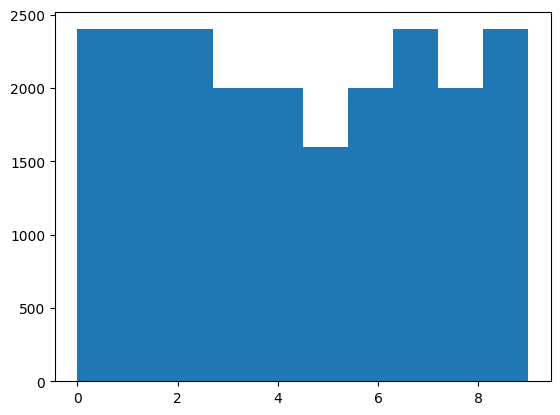

In [76]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])
plt.hist(imgs_label, 10)

Dataset images: 4400 Dataset labels: 4400
Dataset sample -> ..\EuroSAT-split\train\SeaLake\SeaLake_743.tif 9


(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2400.]),
 array([8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ]),
 <BarContainer object of 10 artists>)

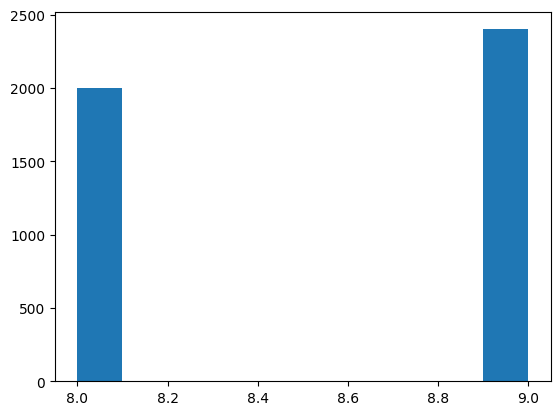

In [77]:
#Select only two classes
classes = ['River', 'SeaLake']

imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

plt.hist(imgs_label, 10)

In [78]:
img, meta, _ = load(imgs_path[0])
print('Shape: ',img.shape)
dict_disp(meta)
print_stats(img)


Shape:  (64, 64, 13)
--------------Dictionary---------------
	 [*] driver : GTiff
	 [*] dtype : uint16
	 [*] nodata : None
	 [*] width : 64
	 [*] height : 64
	 [*] count : 13
	 [*] crs : EPSG:32635
	 [*] transform : | 10.00, 0.00, 373279.38|
| 0.00,-10.00, 6586556.12|
| 0.00, 0.00, 1.00|
	 [*] blockxsize : 64
	 [*] blockysize : 4
	 [*] tiled : False
	 [*] interleave : pixel
-----------------Image Statistics-----------------
[*] Shape           (64, 64, 13)
[*] Max             1203                          
[*] Min             6                             
[*] Mean            458.6834059495192             
[*] Std             395.33595397457344            
[*] Med             337.0                         


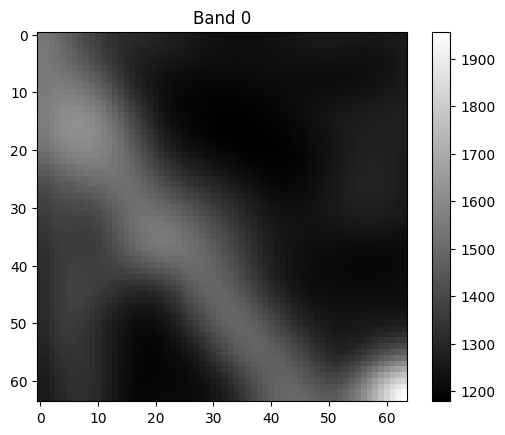

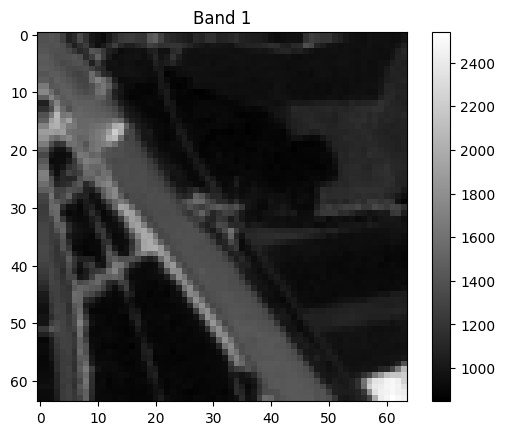

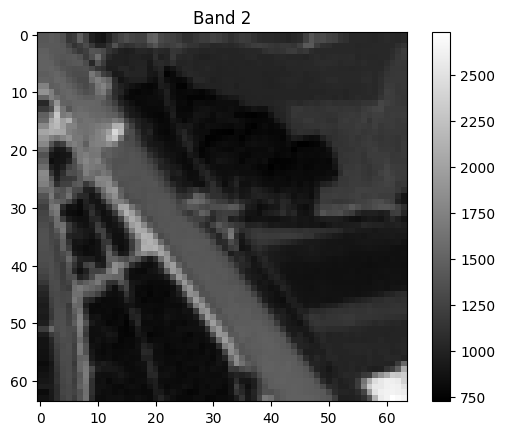

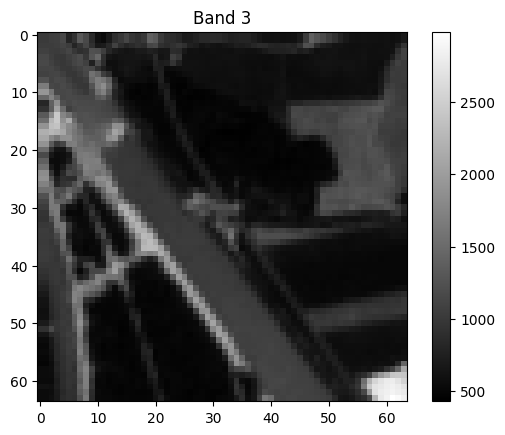

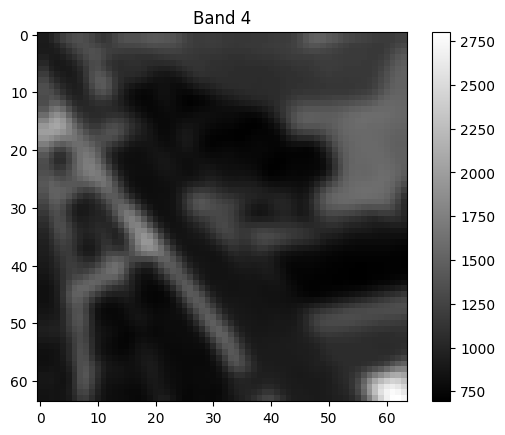

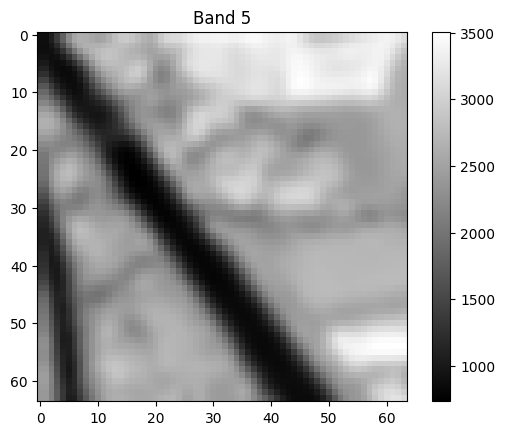

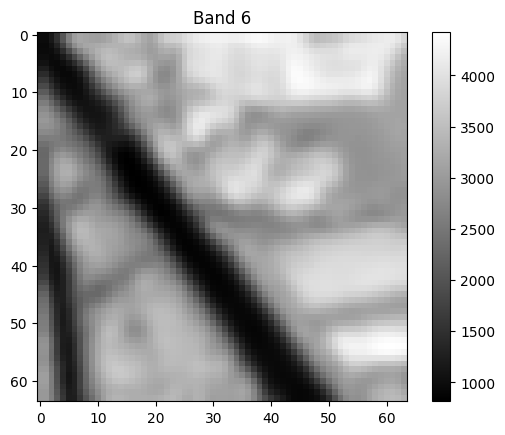

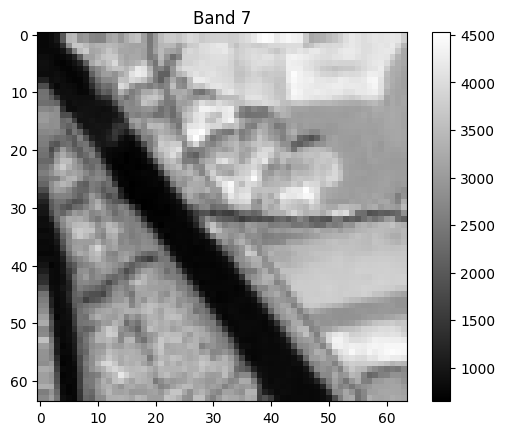

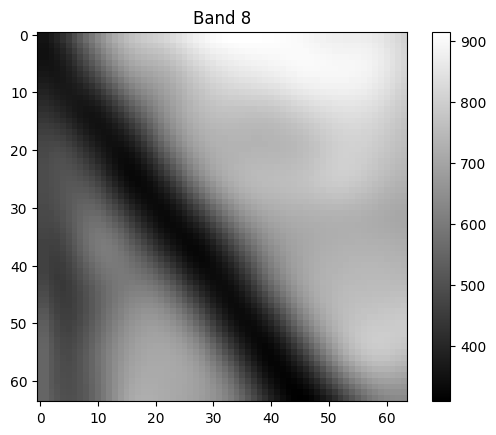

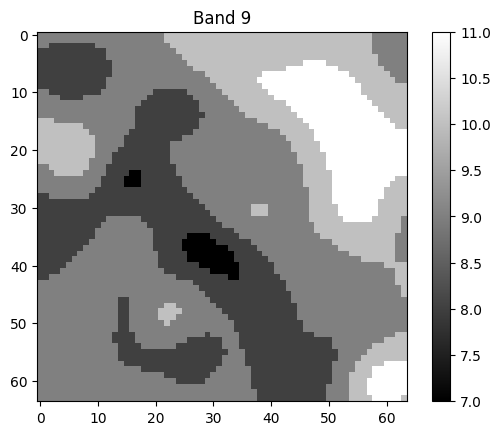

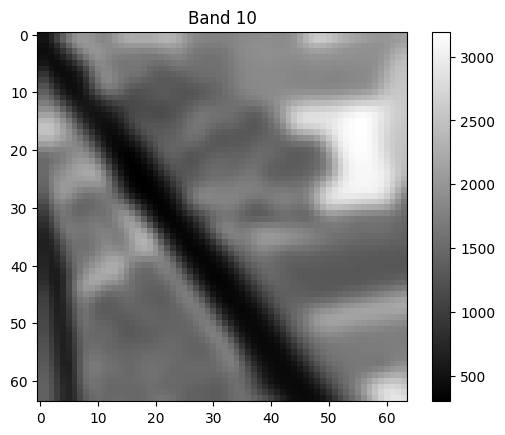

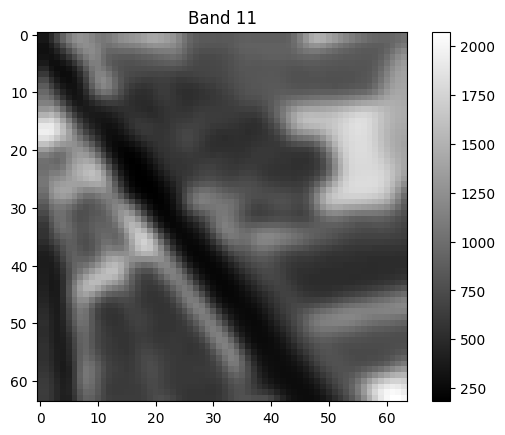

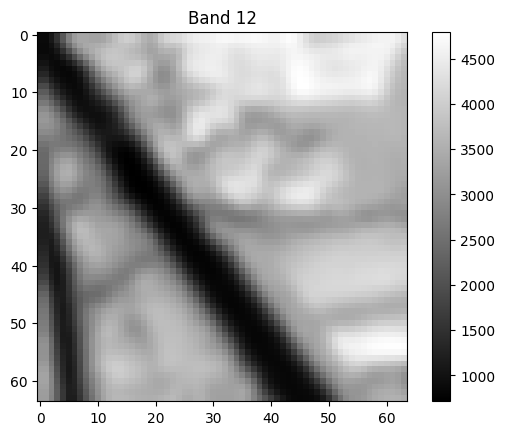

In [65]:
for i in range(13):
    plt.imshow(img[:,:,i], cmap='gray')
    plt.title(f'Band {i}')
    plt.colorbar()
    plt.show()

In [66]:
def percentile_prescaler(img : np.ndarray , perc : list, mmin : list = None) -> np.ndarray:
    '''
        Clip image between minimum and maximum based on the percentile'''

    if len(img.shape) != 3:
        raise Exception('Error: lenght of image shape must be 3 - (space, space, channels)')
    
    if mmin is not None:
        if len(mmin) != img.shape[-1]:
            raise Exception('Error: lenght of mmin must be equals to number of bands')
    
    if len(perc) != img.shape[-1]:
        raise Exception('Error: lenght of perc must be equals to number of bands')


    if mmin is None: mmin = np.nanmin(img, axis=(0,1))

    for i in range(img.shape[-1]):
        mmax = np.nanpercentile(img[:,:,i], perc[i])
        img[:,:,i] = np.clip(img[:,:,i], mmin[i], mmax)
    
    return img

def minmaxscaler(img : np.ndarray, mmin : list = None, mmax : list = None, clip : list = [None, None]) -> np.ndarray: 
    '''
        Apply the min max scaler to the input img:  '''
    

    if len(img.shape) != 3:
        raise Exception('Error: lenght of image shape must be 3 - (space, space, channels)')
    
    if mmin is not None:
        if len(mmin) != img.shape[-1]:
            raise Exception('Error: lenght of mmin must be equals to number of bands')
    
    if mmax is not None:
        if len(mmax) != img.shape[-1]:
            raise Exception('Error: lenght of mmax must be equals to number of bands')
    
    if mmin == None: mmin = np.nanmin(img, axis=(0,1))
    if mmax == None: mmax = np.nanmax(img, axis=(0,1))
    
    for i in range(img.shape[-1]):  
        num = img[:,:,i] - mmin[i]
        den = mmax[i] - mmin[i]
          
        img[:, :, i] = np.divide(num, den, out=np.zeros_like(num)+0.5, where=den != 0)
   
    if (clip[0] is not None) and (clip[1] is not None):
        img = np.clip(img, clip[0], clip[-1])
    
    return img

In [67]:
def load_and_preprocess(img_path, bands=[0,1,2], how=None):
    img, meta, _ = load(img_path)
    img = img[:, :, bands]  # Select relevant bands
    img = img.astype(np.float32)
    if how == 'percentile':
        img = percentile_prescaler(img, [99]*len(bands))
    elif how == 'percentile_minmax':
        img = percentile_prescaler(img, [99]*len(bands))
        img = minmaxscaler(img)
    elif how:
        sys.stderr.write('something is wrong with normalization')
        sys.exit()
            
    return img

In [68]:
def compute_dataset_stats_and_histograms(imgs_path, bands=[0,1,2], max_images=100, how=None):
    min_per_band = None
    max_per_band = None
    sum_per_band = None
    count = 0
    pixel_values_per_band = [[] for _ in bands]

    for idx, path in enumerate(imgs_path):
        img = load_and_preprocess(path, bands, how)

        img_min = np.min(img, axis=(0,1))
        img_max = np.max(img, axis=(0,1))
        img_sum = np.sum(img, axis=(0,1))
        img_count = img.shape[0] * img.shape[1]

        if min_per_band is None:
            min_per_band = img_min
            max_per_band = img_max
            sum_per_band = img_sum
        else:
            min_per_band = np.minimum(min_per_band, img_min)
            max_per_band = np.maximum(max_per_band, img_max)
            sum_per_band += img_sum

        if idx < max_images:
            for i in range(len(bands)):
                pixel_values_per_band[i].extend(img[:, :, i].ravel())

        count += img_count

    mean_per_band = sum_per_band / count

    # Compute percentiles for outlier detection
    p001 = []
    p01 = []
    p99 = []
    p999 = []

    for pixels in pixel_values_per_band:
        p001.append(np.percentile(pixels, 0.1))
        p01.append(np.percentile(pixels, 1))
        p99.append(np.percentile(pixels, 99))
        p999.append(np.percentile(pixels, 99.9))

    stats_df = pd.DataFrame({
        'Band': bands,
        'Min': min_per_band,
        '1st %': p01,
        '0.1st %': p001,
        'Mean': mean_per_band,
        '99th %': p99,
        '99.9th %': p999,
        'Max': max_per_band
    })

    if how == 'percentile_minmax':
        print(stats_df.round(2).to_string(index=False))
    else:
        print(stats_df.round(0).astype(int).to_string(index=False))
    return min_per_band, max_per_band, mean_per_band, pixel_values_per_band, p999


***************************************

Data as it is
 Band  Min  1st %  0.1st %  Mean  99th %  99.9th %   Max
    0  887   1023      980  1266    1687      1871  3228
    1  550    695      669   991    1653      2358 16191
    2  374    419      393   845    1745      2488 14632
    3  141    232      226   602    2099      2866 18892
    4  174    196      192   701    2174      2649  5549
    5  153    167      162  1001    3719      4194  8490
    6  128    144      138  1162    4873      5571 10456
    7   88    116      111  1090    4896      5564 19835
    8   40     51       47   326    1743      2015  2354
    9    1      4        3     9      19        33   129
   10    5     14       10   651    3446      3935 11020
   11    1      5        3   363    2482      3024 12815
   12   91    105      100  1197    5277      5968  9164


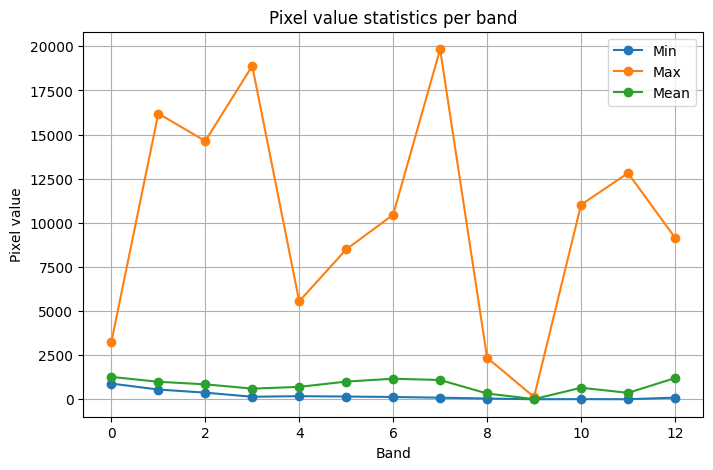

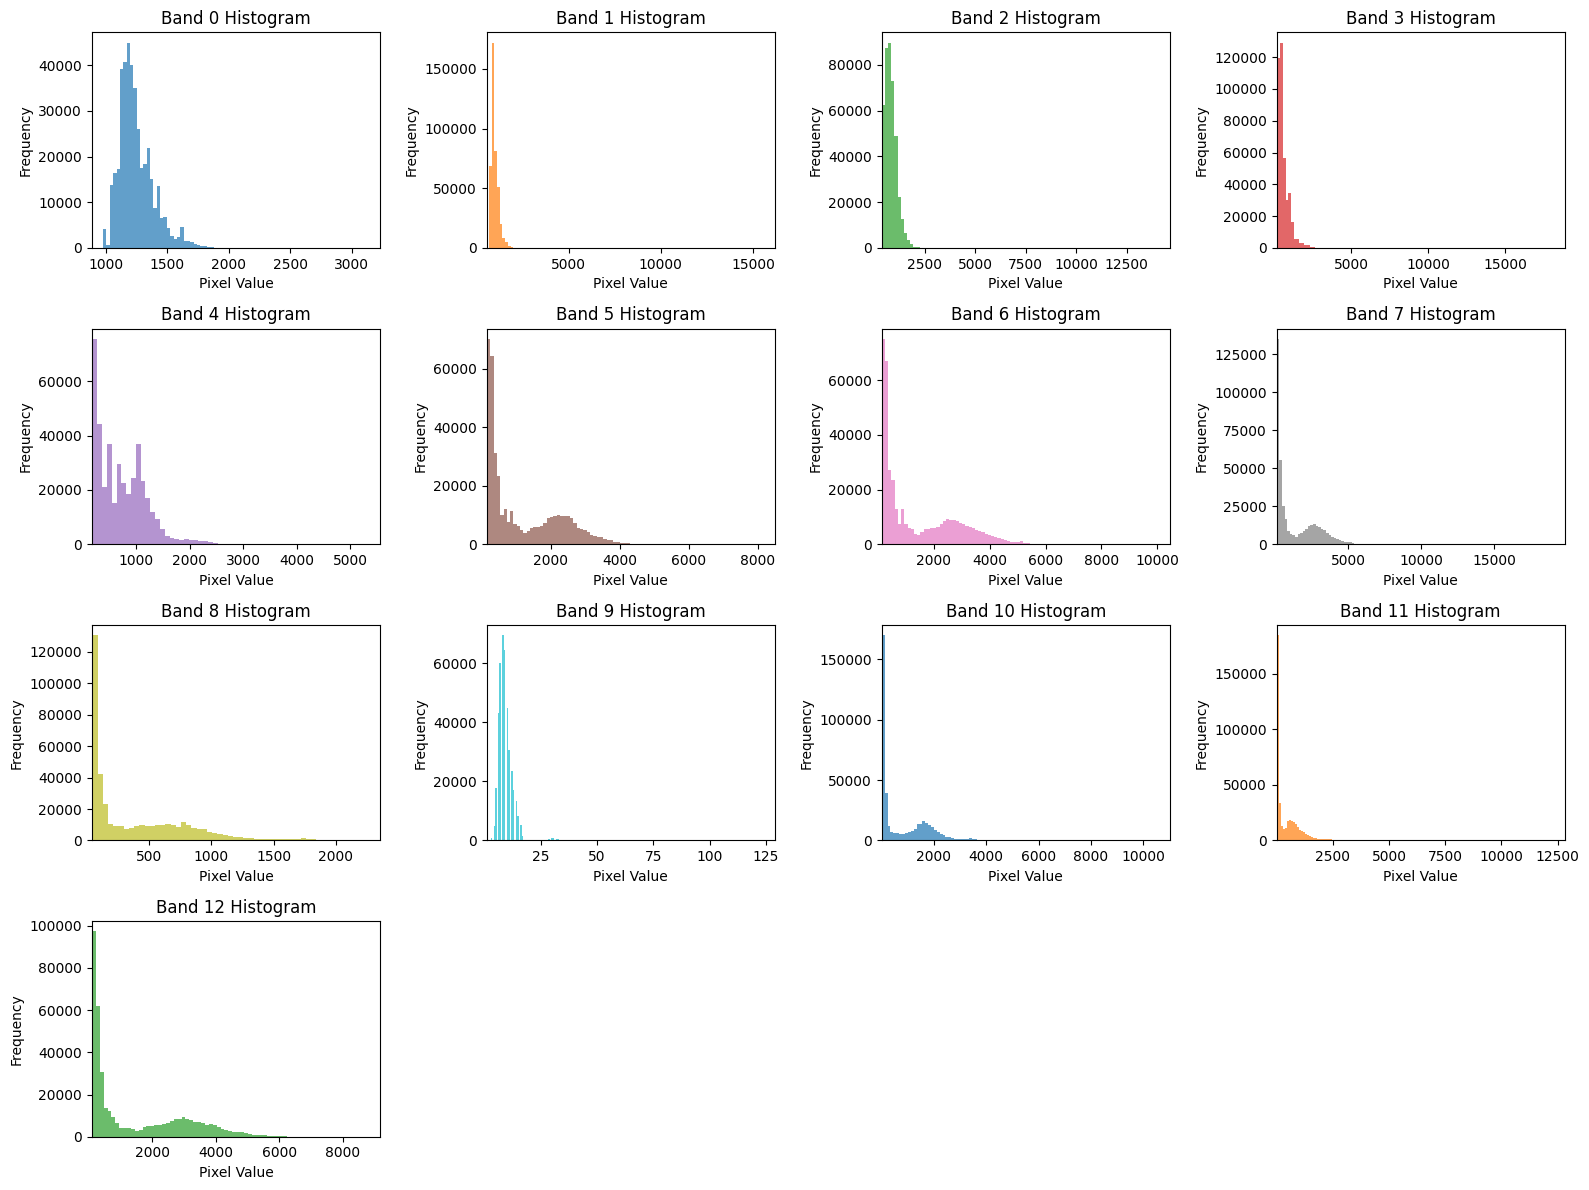

In [26]:
print('\n***************************************')
print('\nData as it is')
# Compute stats and gather histogram data
min_per_band, max_per_band, mean_per_band, pixel_values_per_band, p999 = compute_dataset_stats_and_histograms(
    imgs_path, bands=bands, max_images=100, how=None
)


# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


***************************************

99 Percentile
 Band  Min  1st %  0.1st %  Mean  99th %  99.9th %  Max
    0  887   1023      980  1266    1686      1858 3079
    1  550    694      669   990    1639      2221 5683
    2  374    414      393   844    1736      2362 5755
    3  141    232      226   601    2075      2696 6199
    4  174    196      192   701    2163      2616 4709
    5  153    167      162  1000    3715      4162 4968
    6  128    144      138  1161    4862      5539 6448
    7   88    116      111  1089    4884      5546 6410
    8   40     51       47   326    1743      2015 2319
    9    1      4        3     9      19        33  110
   10    5     14       10   650    3441      3902 6824
   11    1      5        3   362    2470      3019 8873
   12   91    105      100  1196    5269      5965 6813


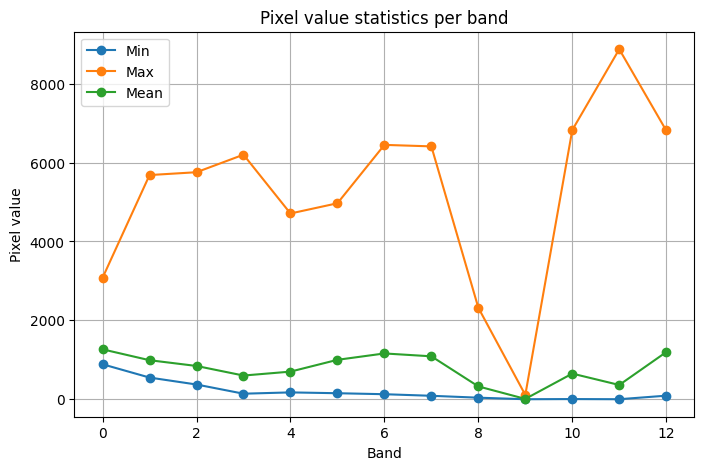

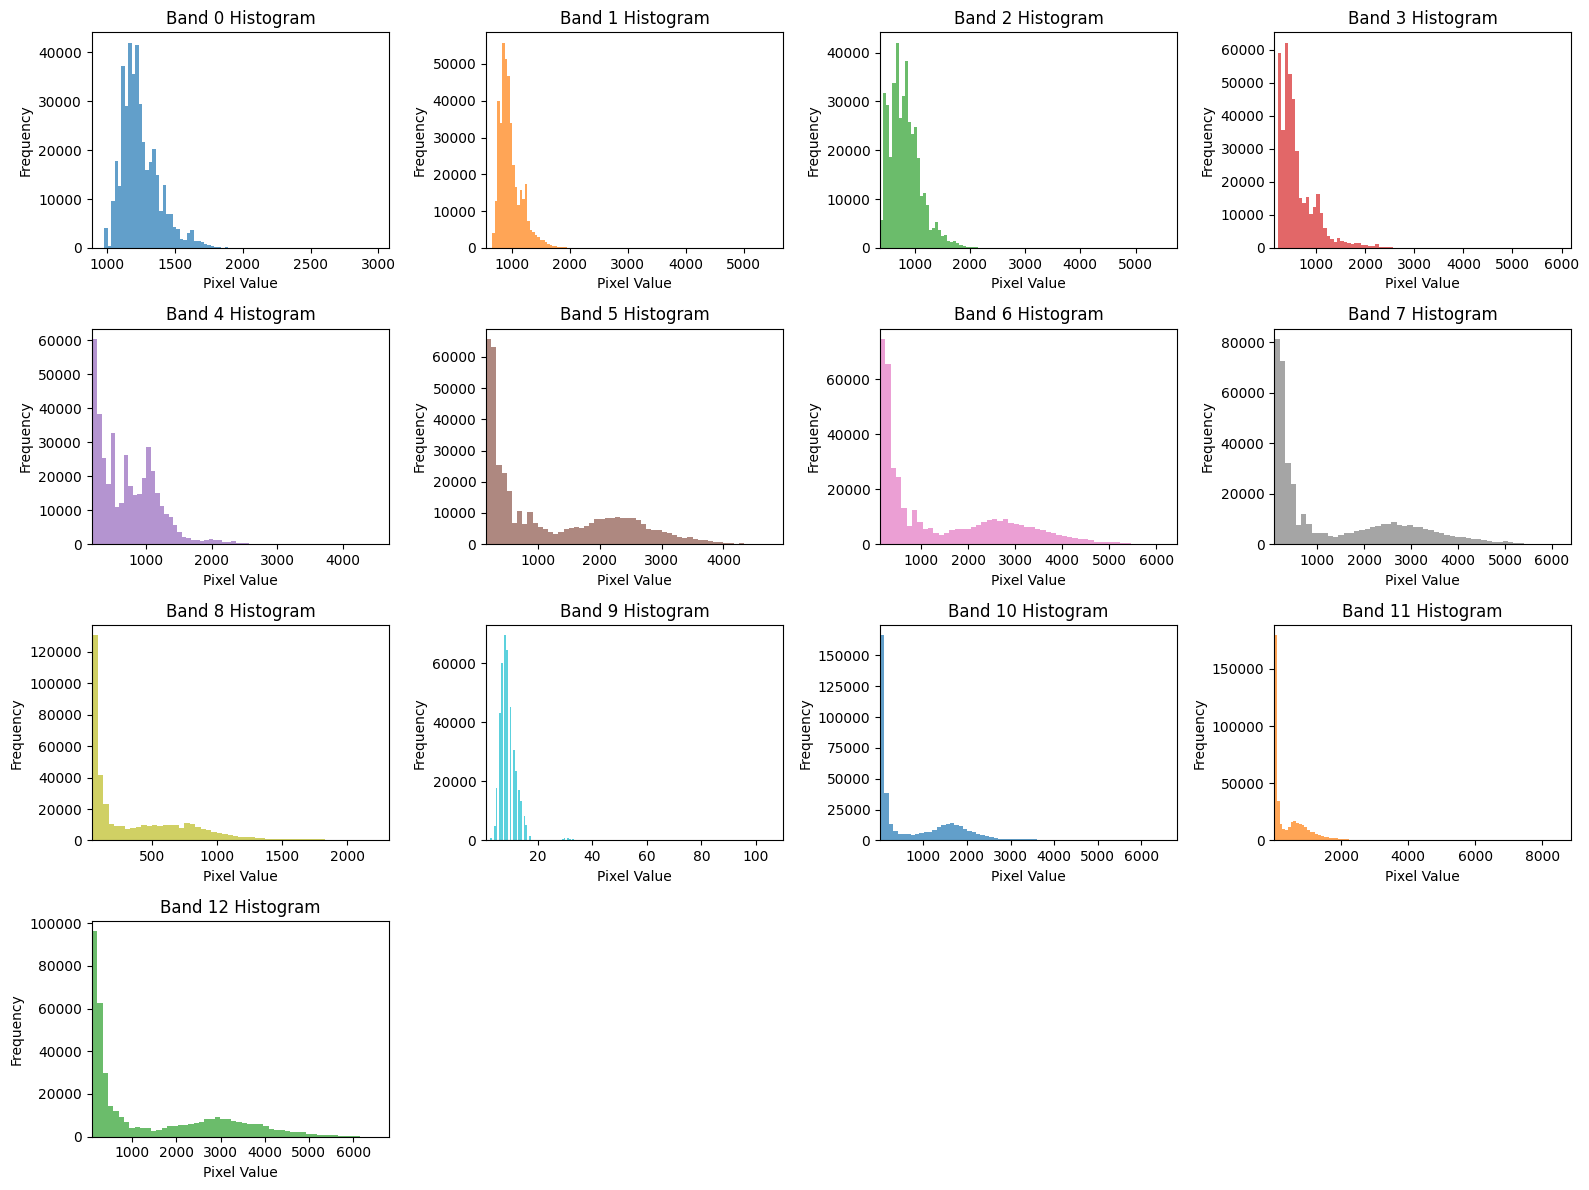

In [24]:
#Remove outliers with percentile PER IMAGE not over the dataset

print('\n***************************************')
print('\n99 Percentile')
# Compute stats and gather histogram data
min_per_band, max_per_band, mean_per_band, pixel_values_per_band, p999 = compute_dataset_stats_and_histograms(
    imgs_path, bands=bands, max_images=100, how='percentile'
)


# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


***************************************

99 Percentile + minmax normalization
 Band  Min  1st %  0.1st %  Mean  99th %  99.9th %  Max
    0  0.0   0.01     0.00  0.43     1.0       1.0  1.0
    1  0.0   0.03     0.01  0.46     1.0       1.0  1.0
    2  0.0   0.03     0.01  0.47     1.0       1.0  1.0
    3  0.0   0.02     0.01  0.42     1.0       1.0  1.0
    4  0.0   0.01     0.00  0.43     1.0       1.0  1.0
    5  0.0   0.00     0.00  0.44     1.0       1.0  1.0
    6  0.0   0.00     0.00  0.43     1.0       1.0  1.0
    7  0.0   0.00     0.00  0.44     1.0       1.0  1.0
    8  0.0   0.00     0.00  0.44     1.0       1.0  1.0
    9  0.0   0.00     0.00  0.52     1.0       1.0  1.0
   10  0.0   0.00     0.00  0.42     1.0       1.0  1.0
   11  0.0   0.00     0.00  0.40     1.0       1.0  1.0
   12  0.0   0.00     0.00  0.44     1.0       1.0  1.0


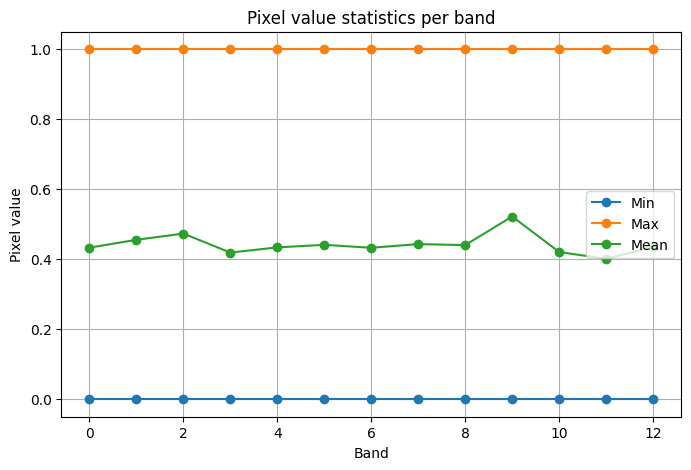

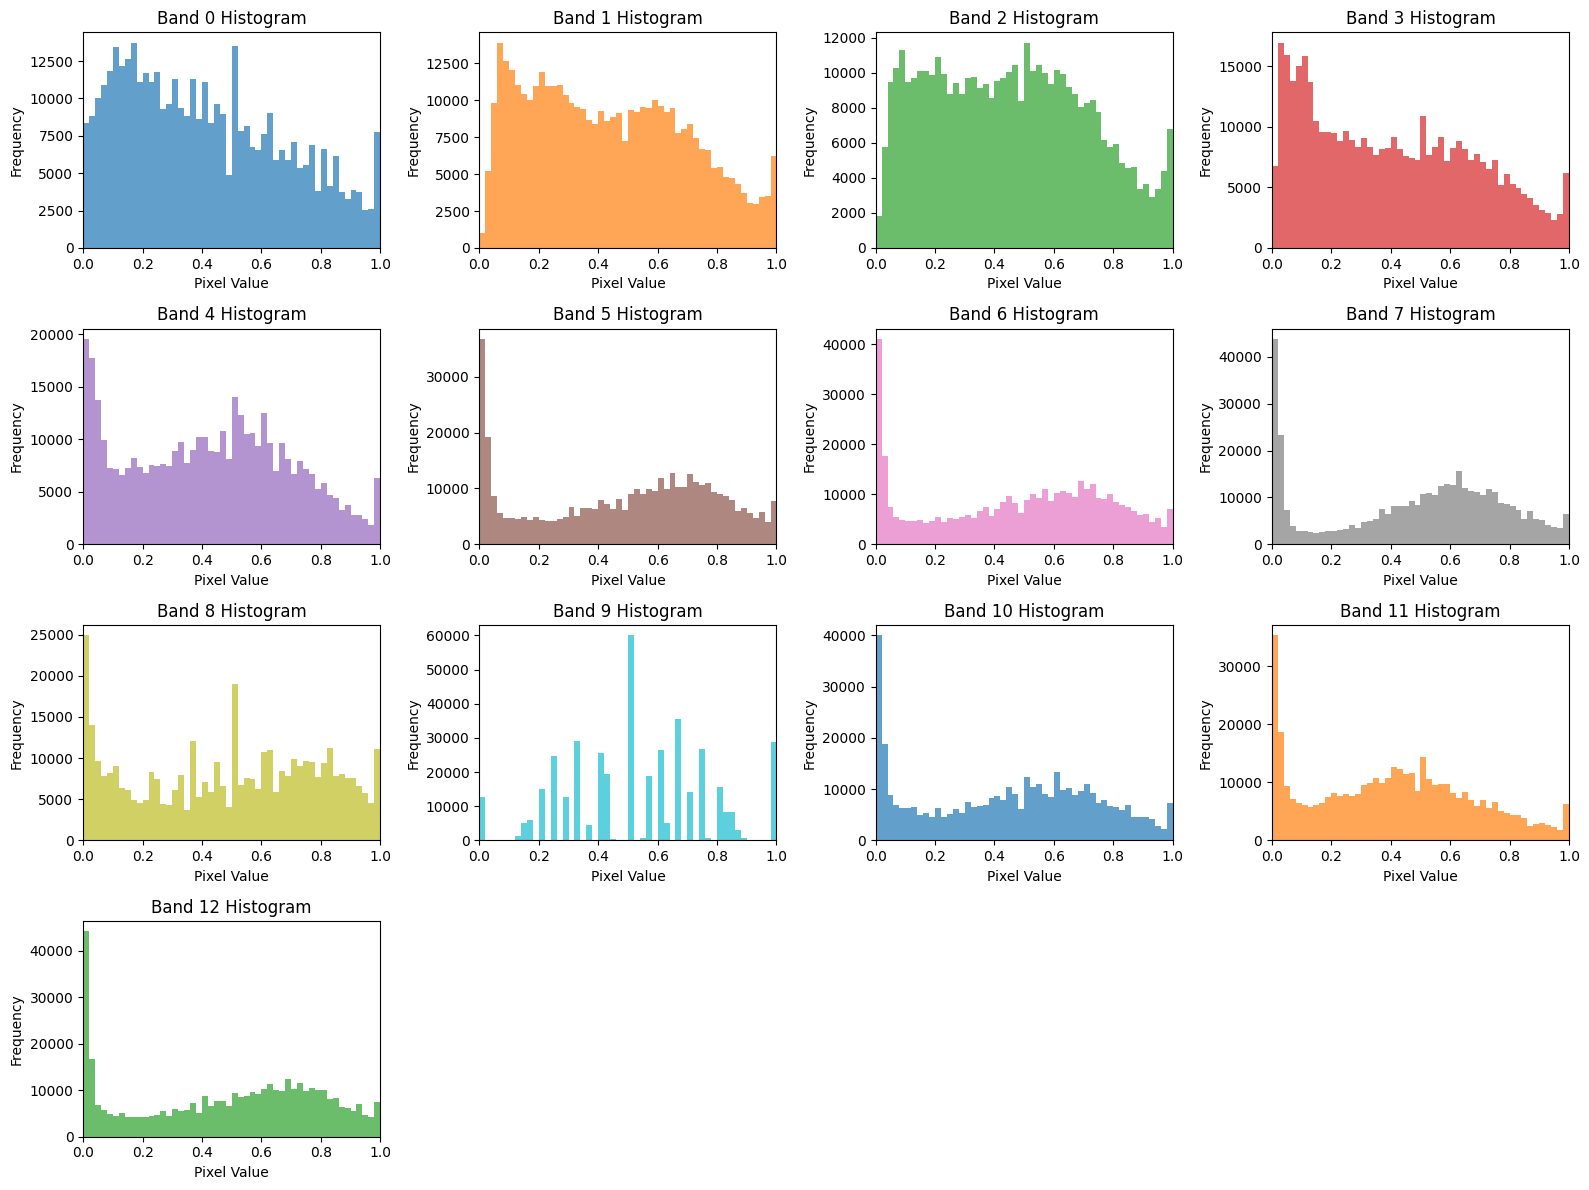

In [36]:
#Remove outliers with percentile PER IMAGE not over the dataset + minmax normalization

print('\n***************************************')
print('\n99 Percentile + minmax normalization')
# Compute stats and gather histogram data
min_per_band, max_per_band, mean_per_band, pixel_values_per_band, p999 = compute_dataset_stats_and_histograms(
    imgs_path, bands=bands, max_images=100, how='percentile_minmax'
)


# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

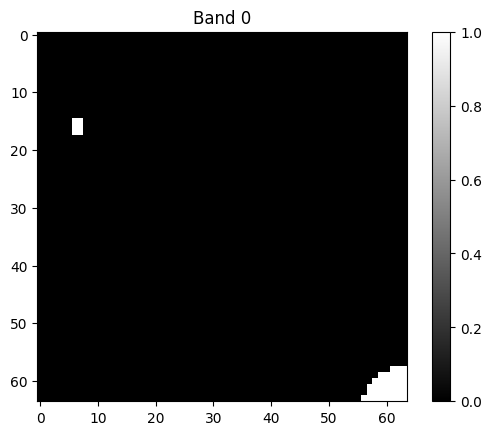

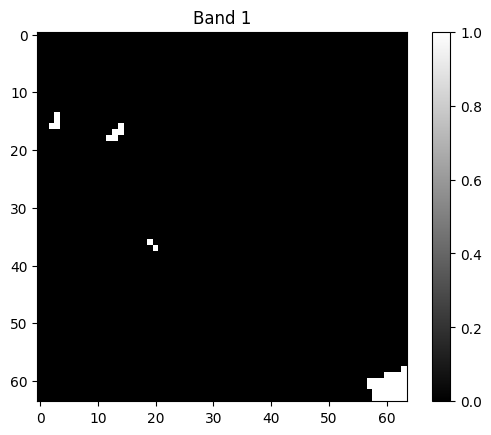

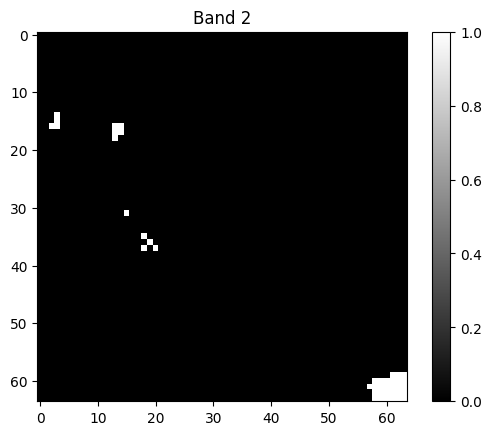

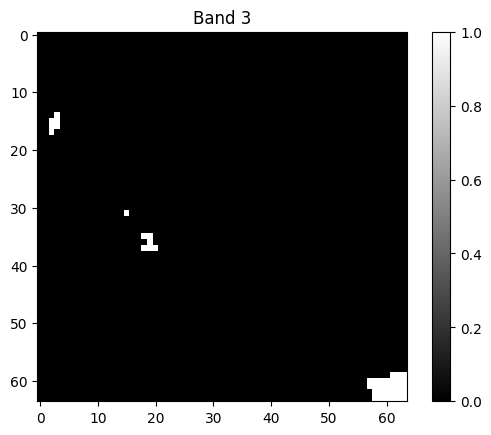

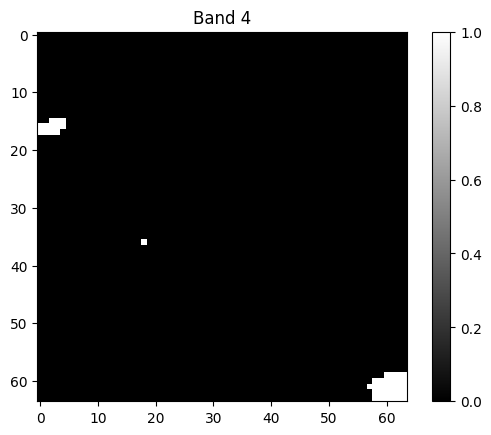

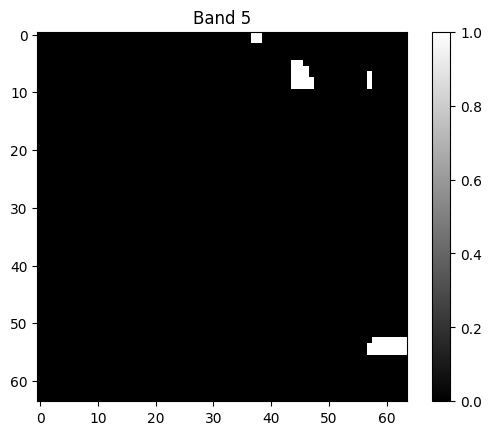

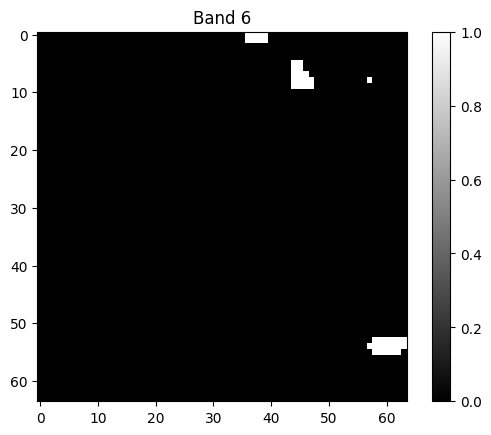

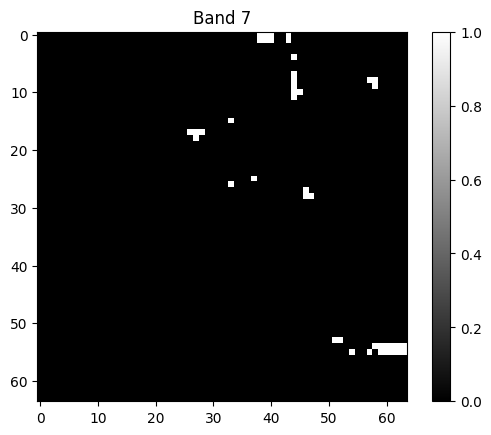

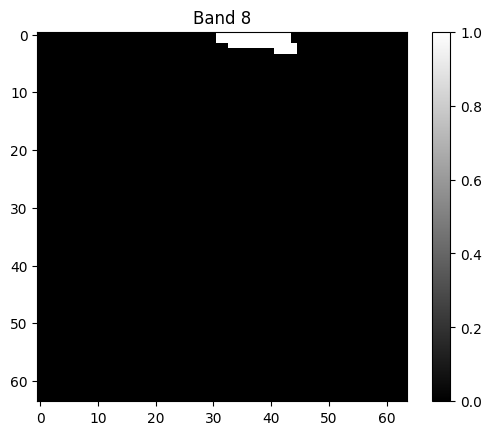

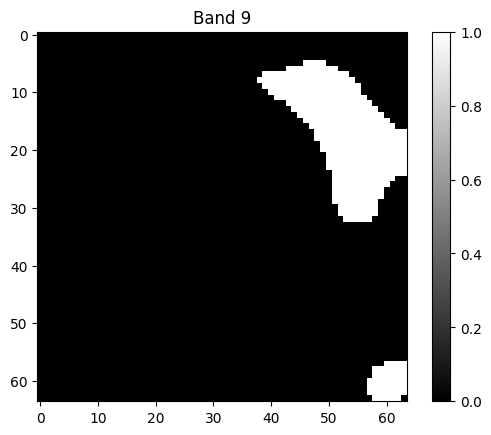

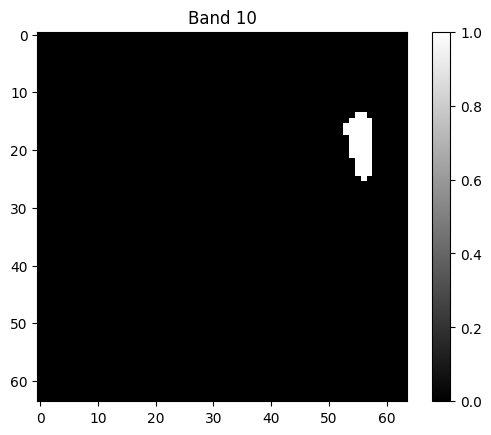

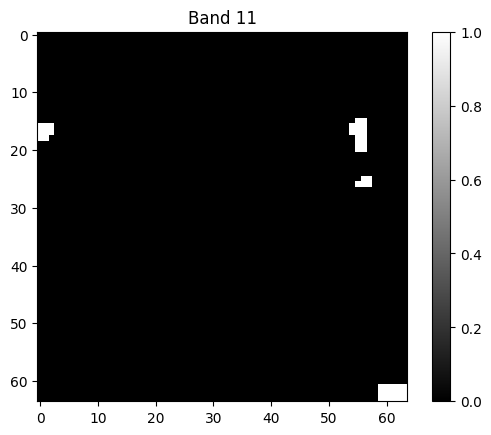

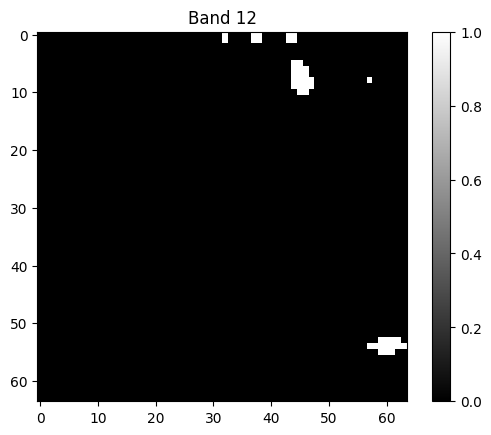

In [71]:
perc_img = percentile_prescaler(img, [99]*len(bands))
minmax_img = minmaxscaler(perc_img)
for i in range(13):
    plt.imshow(minmax_img[:, :, i], cmap='gray', vmin=0, vmax=1)
    plt.title(f'Band {i}')
    plt.colorbar()
    plt.show()

In [82]:
def compute_percentile_and_minmax(imgs_path, bands=[0,1,2], max_images=100):
    pixel_values_per_band = [[] for _ in bands]

    for idx, path in enumerate(imgs_path[:max_images]):
        img, _, _ = load(path)
        img = img[:, :, bands]
        for i, band in enumerate(bands):
            pixel_values_per_band[i].extend(img[:, :, i].ravel())

    # Compute 99th percentiles per band
    p99 = [np.percentile(pixels, 99) for pixels in pixel_values_per_band]
    return p99

def compute_clipped_dataset_stats(imgs_path, bands, p99, max_images=100):
    min_per_band = None
    max_per_band = None
    sum_per_band = None
    count = 0
    pixel_values_per_band = [[] for _ in bands]

    for idx, path in enumerate(imgs_path[:max_images]):
        img, _, _ = load(path)
        img = img[:, :, bands].astype(np.float32)

        # Clip per band
        for i in range(len(bands)):
            img[:, :, i] = np.clip(img[:, :, i], a_min=0, a_max=p99[i])

        img_min = np.min(img, axis=(0, 1))
        img_max = np.max(img, axis=(0, 1))
        img_sum = np.sum(img, axis=(0, 1))
        img_count = img.shape[0] * img.shape[1]

        if min_per_band is None:
            min_per_band = img_min
            max_per_band = img_max
            sum_per_band = img_sum
        else:
            min_per_band = np.minimum(min_per_band, img_min)
            max_per_band = np.maximum(max_per_band, img_max)
            sum_per_band += img_sum

        for i in range(len(bands)):
            pixel_values_per_band[i].extend(img[:, :, i].ravel())

        count += img_count

    mean_per_band = sum_per_band / count
    return min_per_band, max_per_band, mean_per_band, pixel_values_per_band


def normalize_images_minmax(img, min_val, max_val):
    norm_img = np.empty_like(img, dtype=np.float32)
    for i in range(img.shape[2]):
        norm_img[:, :, i] = (img[:, :, i] - min_val[i]) / (max_val[i] - min_val[i] + 1e-8)
    return np.clip(norm_img, 0, 1)


***************************************

99 Percentile + minmax normalization OVER THE DATASET
 Band  Min  Mean  Max
    0  0.0  0.32  1.0
    1  0.0  0.37  1.0
    2  0.0  0.35  1.0
    3  0.0  0.25  1.0
    4  0.0  0.32  1.0
    5  0.0  0.26  1.0
    6  0.0  0.25  1.0
    7  0.0  0.24  1.0
    8  0.0  0.21  1.0
    9  0.0  0.42  1.0
   10  0.0  0.24  1.0
   11  0.0  0.18  1.0
   12  0.0  0.25  1.0


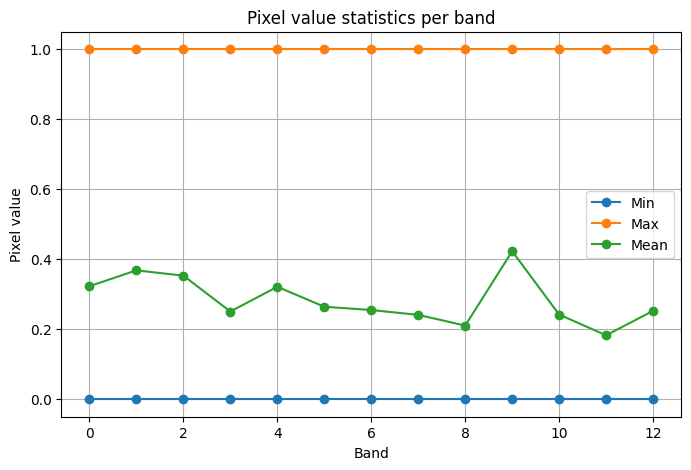

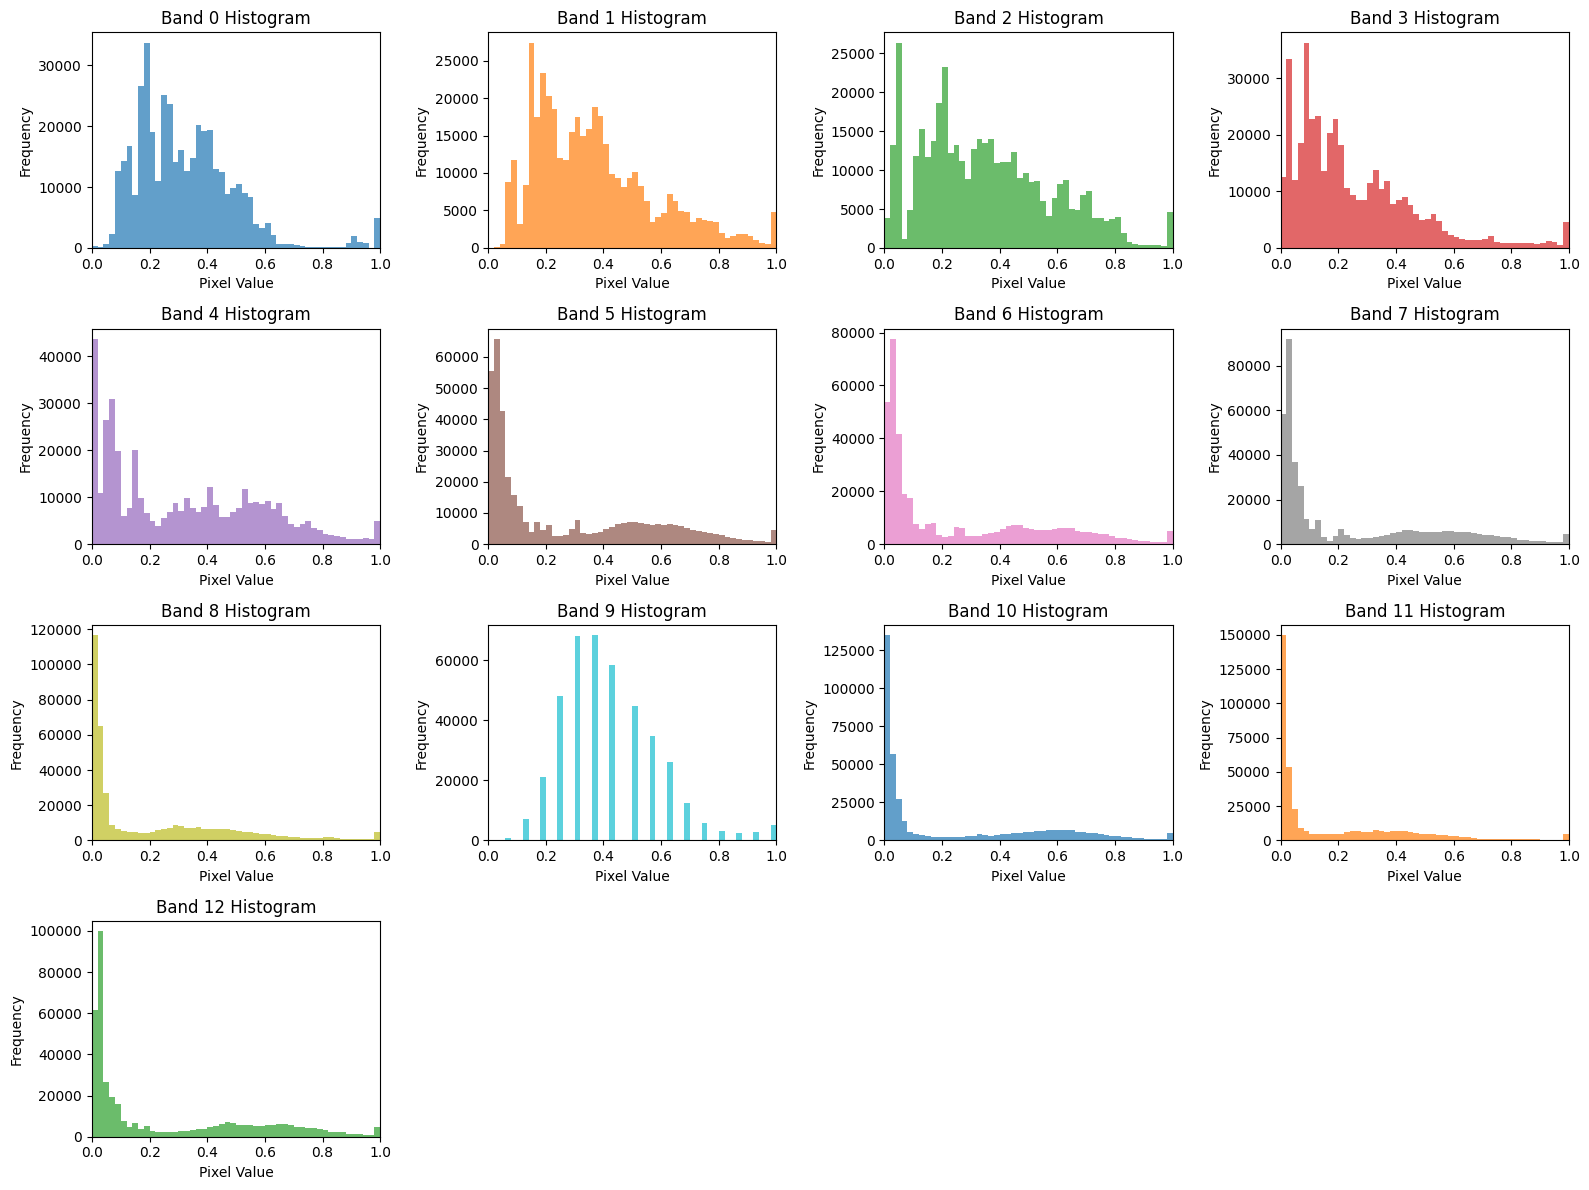

In [85]:

# === Main Execution Block ===
print('\n***************************************')
print('\n99 Percentile + minmax normalization OVER THE DATASET')

# Step 1: Compute 99th percentile
p99 = compute_percentile_and_minmax(imgs_path, bands=bands, max_images=100)

# Step 2: Compute stats after clipping
Min_per_band, Max_per_band, mean_per_band, pixel_values_per_band = compute_clipped_dataset_stats(
    imgs_path, bands=bands, p99=p99, max_images=100
)



min_per_band = None
max_per_band = None
sum_per_band = None
count = 0
pixel_values_per_band = [[] for _ in bands]

for idx, path in enumerate(imgs_path[:100]):
    img, _, _ = load(path)
    img = img[:, :, bands].astype(np.float32)

    # Clip per band
    for i in range(len(bands)):
        img[:, :, i] = np.clip(img[:, :, i], a_min=0, a_max=p99[i])

    img = normalize_images_minmax(img, Min_per_band, Max_per_band) #normalized_img

    img_min = np.min(img, axis=(0, 1))
    img_max = np.max(img, axis=(0, 1))
    img_sum = np.sum(img, axis=(0, 1))
    img_count = img.shape[0] * img.shape[1]

    if min_per_band is None:
        min_per_band = img_min
        max_per_band = img_max
        sum_per_band = img_sum
    else:
        min_per_band = np.minimum(min_per_band, img_min)
        max_per_band = np.maximum(max_per_band, img_max)
        sum_per_band += img_sum

    for i in range(len(bands)):
        pixel_values_per_band[i].extend(img[:, :, i].ravel())

    count += img_count

mean_per_band = sum_per_band / count


stats_df = pd.DataFrame({
    'Band': bands,
    'Min': min_per_band,
    'Mean': mean_per_band,
    'Max': max_per_band
})

print(stats_df.round(2).to_string(index=False))
    
# Plot min, max, mean
plt.figure(figsize=(8,5))
plt.plot(bands, min_per_band, label='Min', marker='o')
plt.plot(bands, max_per_band, label='Max', marker='o')
plt.plot(bands, mean_per_band, label='Mean', marker='o')
plt.legend()
plt.title("Pixel value statistics per band")
plt.xlabel("Band")
plt.ylabel("Pixel value")
plt.grid(True)
plt.show()

# Plot histograms per band
fig, axes = plt.subplots(len(bands) // 4 + 1, 4, figsize=(16, 3 * (len(bands) // 4 + 1)))
axes = axes.flatten()

for i, band_idx in enumerate(bands):
    axes[i].hist(pixel_values_per_band[i], bins=50, color=f"C{i}", alpha=0.7)
    axes[i].set_title(f'Band {band_idx} Histogram')
    axes[i].set_xlim(min_per_band[i], max_per_band[i])
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()